[11:01:18] WARNING: ../src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[4, 4.5, 0.1]
[6, 1750, 2]
0
0.0
Time: 1218.5551296967858
Particle 0 mass: 1.0
Particle 1 mass: 1.912526338174731e-05
Particle 2 mass: 1.3009823919612332e-05
Particle 3 mass: 1.0622599311971938e-05
Particle 4 mass: 1.5552431127518644e-05
Particle 5 mass: 0.004382912427393109
Particle 6 mass: 0.0033416809997694197
Particle 7 mass: 0.005813777970653769
Particle 8 mass: 0.00508578583967279
Particle 9 mass: 0.005586370930318846
Particle 10 mass: 0.005069712599241888
346472202
848020557
Merging particle 2 into 5
{730930102: [array([[1.00000010e+03, 2.00000020e+03, 3.00000030e+03, ...,
        9.97000100e+05, 9.98000100e+05, 9.99000100e+05],
       [8.43778021e-02, 8.43627401e-02, 8.50277816e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.39061720e-01, 3.7367481

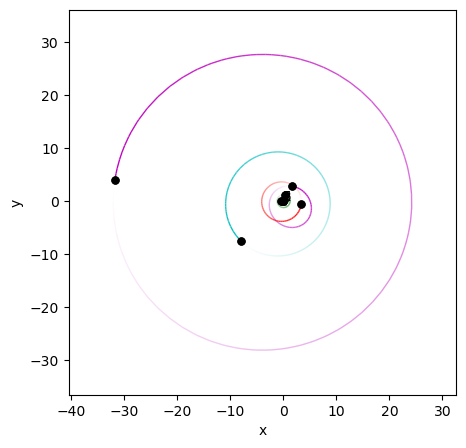

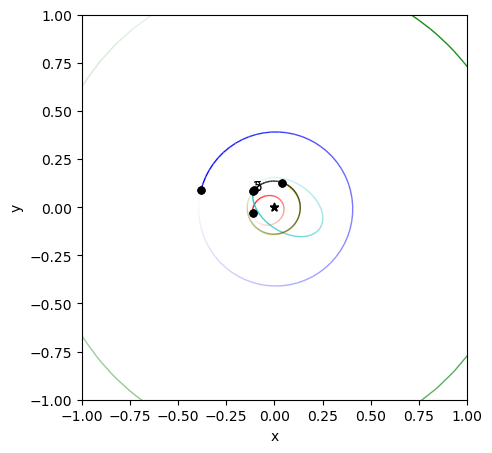

In [14]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
import random
import pdb
import pickle
from rebound import hash as h
from spock import FeatureClassifier
from spock import DeepRegressor


G = 6.67408*10**(-11)   # gravitational constant 
Mearth = 5.9722*10**24  # kg
Rearth = 6.371*10**6  # meters
Msun = 1.98911*10**30 # kg
Rsun = 6.95*10**8 # meters
Mjup = 1.898*10**27  # kg
Rjup = 7.1492*10**7 # meters
year = 365.25*24*60*60  # years in seconds
AU = (G*Msun*(year**2)/(4.*np.pi**2))**(1./3.)  # meters

#import sys
#ID = int(sys.argv[1])


def perfect_merger(sim_pointer, collided_particles_index):
  # if the boolean in orbitalelementshash is True, that means that the particle is still in the sim, otherwise, False
    sim = sim_pointer.contents
    ps = sim.particles
    print("Time: " + str(sim.t))
    i = collided_particles_index.p1   # p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 
    # if i > j: # Swap
    #   temp = j
    #   j = i
    #   i = temp
    for p in range(len(ps)):
        print("Particle " + str(p) + " mass: " + str(sim.particles[p].m))
    hashi = ps[i].hash.value
    hashj = ps[j].hash.value
    print(hashi)
    print(hashj)
    op = rebound.OrbitPlot(sim, color=True)
    op1 = rebound.OrbitPlot(sim, xlim = [-1, 1], ylim = [-1, 1], color = True)
    print("Merging particle {} into {}".format(j, i))
    #print("Particle 1: x: " + str(ps[1].x) + " Particle 1: y: " + str(ps[1].y))
    #print("Particle 2: x: " + str(ps[2].x) + " Particle 2: y: " + str(ps[2].y))
    # op.ax.title("Merging particle {} into {}".format(j, i))
    op.ax.text(ps[i].x, ps[i].y, str(i))
    op.ax.text(ps[j].x, ps[j].y, str(j))
    op1.ax.text(ps[i].x, ps[i].y, str(i))
    op1.ax.text(ps[j].x, ps[j].y, str(j))

    # Merging 
    #print(ps[i].m)
    #print(ps[i].v)
    #collision_energy = (min(ps[i].m, ps[j].m) * abs(ps[i].v - ps[j].v)**2) / (2 * (ps[i].m + ps[j].m))
    #print("Energy of collision between particle {} and {}: {}".format(i, j, collision_energy))
    total_mass = ps[h(hashi)].m + ps[h(hashj)].m
    merged_planet = (ps[h(hashi)] * ps[h(hashi)].m + ps[h(hashj)] * ps[h(hashj)].m)/total_mass # conservation of momentum

    # merged radius assuming a uniform density
    merged_radius = (ps[h(hashi)].r**3 + ps[h(hashj)].r**3)**(1/3)

    ps[h(hashi)] = merged_planet   # update p1's state vector (mass and radius will need corrections)
    ps[h(hashi)].m = total_mass    # update to total mass
    ps[h(hashi)].r = merged_radius # update to joined radius
    #orbitalelements = orbitalelements.tolist()
    #np.delete(orbitalelementsdict["orbitalelements"], j - 1) # remove the particle with index j from the orbital elements array
    #orbitalelementslength = orbitalelementslength - 1
    #print(orbitalelementslength)
    # orbitalelementsdict["orbitalelements"] = np.array(orbitalelementsdict["orbitalelements"]) 
    # np.save('orbitalelements', orbitalelements)
    #print(hashj)
    #print([str(h("p1").value), str(h("p2").value), str(h("p3").value), str(h("p4").value), str(h("p5").value)])
    if hashj in [h("p1").value, h("p2").value, h("p3").value, h("p4").value, h("p5").value]: # these are the hash arguments of the planets in the inner system
      multiplicity["num"] -= 1
    orbitalelementshash[hashj][1] = False # take the index j particle (larger index) out of the simulation
    return 2 # remove particle with index j



# SIMULATION SETUP

# FOR THE ARGUMENTS FOR THE TEMPLATE FUNCTIONS: roughly 2-3 collisiosn between inner systems sum to the inner planet of TOI-969
# ALSO: Use of SPOCK for narrowing down templates. Draw randomly from inner + outer and then do a SPOCK: if stable, quit
# SPOCK also has instability time estimator

def inner_template(n,m,a):
    sim = rebound.Simulation()
    sim.integrator = "mercurius"
    #sim.G = 6.6743e-11 # m^3 / kg s^2
    #sim.exit_max_distance = 500 * AU
    # sim.dt = 0.00547570157 / 20
    sim.ri_mercurius.safe_mode = 0 # turning safe mode off
    sim.ri_mercurius.hillfrac = 5
    sim.ri_whfast.safe_mode = 0 # turning whfast safe mode off
    # same as outer template!
    Mp_out = np.random.normal(m, m/4) * Mearth
    Mstar = 1*Msun
    sim.add(m = Mstar/Msun)
    A = 0.5*(2*Mp_out/(3*Mstar))**(1./3)
    K = np.random.uniform(8, 10) # maybe also draw K from some random distribution? e.g. 4 to 6
    a_iplus1_a_i = (1+K*A)/(1-K*A)
    a_list = np.zeros(n)
    m_list = np.zeros(n)
    r_list = np.zeros(n)
    e_list = np.zeros(n)
    omega_list = np.zeros(n)
    Omega_list = np.zeros(n)
    M_list = np.zeros(n)
    inc_list = np.zeros(n)
    a_list[round(n / 2) - 1] = np.random.normal(a, a/12)*(1-K*A)
    for i in range(round(n / 2) - 2, -1, -1):
#         print(i)
        a_list[i] = a_list[i + 1]/a_iplus1_a_i
    for i in range(round(n / 2), n):
        a_list[i] = a_list[i - 1]*a_iplus1_a_i
#     print(a_list)
    for i in range(n):
        m_list[i] = np.random.normal(m, m/4) * (Mearth/Msun)
        r_list[i] = 0.7 * m_list[i] ** (0.63) * (Rearth/AU)
        e_list[i] = e = np.random.rayleigh(scale = 0.035)
        omega_list[i] = random.uniform(0, 2 * np.pi)
        Omega_list[i] = random.uniform(0, 2 * np.pi)
        M_list[i] = random.uniform(0, 2 * np.pi)
        inc_list[i] = np.random.rayleigh(scale = 0.0175)
    for i in range(n):
        sim.add(m = m_list[i], 
                a = a_list[i], 
                hash = "inner_p" + str(i), 
                r = r_list[i], 
                e = e_list[i], 
                inc = inc_list[i], 
                omega = omega_list[i], 
                Omega = Omega_list[i], 
                M = M_list[i])
    ps = sim.particles
    return sim
    

def outer_template(simulation, n, m, a):
    # maybe make Mp_out the mass of the middle planet
    # draw masses directly for both the inner and outer system
    sim = simulation
    Mp_out = np.random.normal(m, m/4) * Mearth
    Mstar = 1*Msun
    A = 0.5*(2*Mp_out/(3*Mstar))**(1./3)
    K = np.random.uniform(5, 8) # maybe also draw K from some random distribution? e.g. 4 to 6
    a_iplus1_a_i = (1+K*A)/(1-K*A)
    a_list = np.zeros(n)
    m_list = np.zeros(n)
    r_list = np.zeros(n)
    e_list = np.zeros(n)
    omega_list = np.zeros(n)
    Omega_list = np.zeros(n)
    M_list = np.zeros(n)
    inc_list = np.zeros(n)
    a_list[round(n / 2) - 1] = np.random.normal(a, a/12)*(1-K*A)
    #print(a_list[round(n / 2) - 1])
    for i in range(round(n / 2) - 2, -1, -1):
        a_list[i] = a_list[i + 1]/a_iplus1_a_i
        #print(a_list[i + 1]/a_iplus1_a_i)
    for i in range(round(n / 2), n):
        a_list[i] = a_list[i - 1]*a_iplus1_a_i
    for i in range(n):
        m_list[i] = np.random.normal(m, m/4) *(Mearth/Msun)
        r_list[i] = 1 * Rjup/AU
        e_list[i] = random.uniform(0, 0.07)
        omega_list[i] = random.uniform(0, 2 * np.pi)
        Omega_list[i] = random.uniform(0, 2 * np.pi)
        M_list[i] = random.uniform(0, 2 * np.pi)
        inc_list[i] = random.uniform(0, 0.035)
    for i in range(n):
        sim.add(m = m_list[i], 
                a = a_list[i], 
                hash = "outer_p" + str(i), 
                r = r_list[i],
                e = e_list[i], 
                inc = inc_list[i], 
                omega = omega_list[i], 
                Omega = Omega_list[i], 
                M = M_list[i])
    sim.dt = (1/20)*np.amin([particle.P for particle in sim.particles[1::]])
    sim.ri_ias15.min_dt = 1e-2 * sim.dt
    sim.move_to_com()
    ps = sim.particles
    return sim


feature_model = FeatureClassifier()
deep_model = DeepRegressor()

# inner_templates = [[5, 3, 0.02], [5, 4.5, 0.02], [3, 3, 0.1], [6, 3, 0.02], [6, 4.5, 0.02]]

# # consider n = 4,5 for outer templates

outer_templates = [[6, 1400, 2], 
                  [6, 500, 2],
                  [6, 500, 3],
                  [6, 500, 4],
                  [6, 500, 5],
                  [6, 1400, 3], 
                  [6, 1400, 4], 
                  [6, 1400, 5], 
                  [6, 1400, 10], 
                  [3, 1750, 2], 
                  [3, 1750, 3], 
                  [3, 1750, 4],
                  [3, 1750, 5],
                  [3, 1750, 10],
                  [6, 1750, 2],
                  [6, 1750, 3],
                  [6, 1750, 4],
                  [2, 1750, 1],
                  [2, 1750, 2],
                  [2, 1750, 3],
                  [2, 1750, 4],
                  [2, 1750, 5],
                  [2, 1750, 10]]


inner_templates = [[3, 3, 0.02],
                   [3, 3, 0.04],
                   [3, 3, 0.1],
                   [2, 4.5, 0.02],
                   [2, 4.5, 0.1],
                   [4, 3, 0.02],
                   [4, 3, 0.1],
                   [4, 4.5, 0.02],
                   [4, 4.5, 0.1]]
                   

# outer_templates = [[3, 1750, 2],
#                   [3, 1750, 3],
#                   [2, 1750, 2],
#                   [2, 1750, 3],
#                   [4, 1750, 2],
#                   [4, 1750, 3]]


in_random = random.choice(inner_templates)
print(in_random)
out_random = random.choice(outer_templates)
print(out_random)
sim = outer_template(inner_template(in_random[0], in_random[1], in_random[2]), out_random[0], out_random[1], out_random[2])
#sim.status()
median, lower, upper = deep_model.predict_instability_time(sim, samples=10000)
print(int(median))
stability_p = feature_model.predict_stable(sim)
print(stability_p)
if median > 0 and stability_p < 1:
    multiplicity = {"num": 5}
    integrationtime = 1000000
    time_between_outputs = 0.1
    n_between_writeouts = int((integrationtime / time_between_outputs) / 1000)
    #print(n_between_writeouts)
    Noutputs = int(integrationtime / time_between_outputs)
    #print(Noutputs / n_between_writeouts)
    sim.collision = "direct"
    ps = sim.particles
    num_particles = len(sim.particles) # includes star
    times = np.linspace(0, integrationtime, Noutputs)
    orbitalelementshash = {}
    for i in range(len(ps)):
    #print(ps[i])
        orbitalelementshash[ps[i].hash.value] = [np.zeros((5, int(Noutputs / n_between_writeouts) - 1)), True]
    del orbitalelementshash[0] # getting rid of the star   
    #print(orbitalelementshash)
    sim.collision_resolve_keep_sorted = 1
    
    sim.collision_resolve = perfect_merger # user defined collision resolution function`
    j = 0
    for i,time in enumerate(times):
        sim.integrate(time)
        #orbits = sim.calculate_orbits()
        #print(sim.t)
        if i % n_between_writeouts == 0 and i != 0: # writeout to .npy periodically every n times we update orbitalelements (note that this != every n timesteps!)
            for a in range(len(ps) - 1):
                if ps[h(ps[a + 1].hash.value)].a > 1000:
                    orbitalelementshash[ps[a + 1].hash.value][1] = False # remove any particle that is more than 1000 AU away
            for a in range(len(ps) - 1):
                if ps[h(ps[a + 1].hash.value)].a < 0: # remove any particles that get a negative sma
                    orbitalelementshash[ps[a + 1].hash.value][1] = False
            # check for if any sma go beyond like 500 AU or something
                if orbitalelementshash[ps[a + 1].hash.value][1]:
                    orbitalelementshash[ps[a + 1].hash.value][0][0][j] = time
                    orbitalelementshash[ps[a + 1].hash.value][0][1][j] = ps[h(ps[a + 1].hash.value)].a
                    orbitalelementshash[ps[a + 1].hash.value][0][2][j] = ps[h(ps[a + 1].hash.value)].e
                    orbitalelementshash[ps[a + 1].hash.value][0][3][j] = ps[h(ps[a + 1].hash.value)].inc
                    orbitalelementshash[ps[a + 1].hash.value][0][4][j] = ps[h(ps[a + 1].hash.value)].m
                    #orbitalelementshash[ps[a + 1].hash.value][0][4][i] = ps[h(ps[a + 1].hash.value)].omega
                    #orbitalelementshash[ps[a + 1].hash.value][0][5][i] = ps[h(ps[a + 1].hash.value)].Omega
                    #orbitalelementshash[ps[a + 1].hash.value][0][6][i] = ps[h(ps[a + 1].hash.value)].M
                else:
                    orbitalelementshash[ps[a + 1].hash.value][0][0][j] = time
                    orbitalelementshash[ps[a + 1].hash.value][0][1][j] = 0
                    orbitalelementshash[ps[a + 1].hash.value][0][2][j] = 0
                    orbitalelementshash[ps[a + 1].hash.value][0][3][j] = 0
                    orbitalelementshash[ps[a + 1].hash.value][0][4][j] = 0
                    #orbitalelementshash[ps[a + 1].hash.value][0][4][i] = 0
                    #orbitalelementshash[ps[a + 1].hash.value][0][5][i] = 0
                    #orbitalelementshash[ps[a + 1].hash.value][0][6][i] = 0
            j += 1
          #  np.save(filename, orbitalelementshash)
          #print(len(ps))
    
    #with open('multiplicity_' + str(ID) + '.pickle', 'wb') as handle2:
    #  pickle.dump(multiplicity["num"], handle2, protocol=pickle.HIGHEST_PROTOCOL)
    #print(orbitalelementshash)
    #print(multiplicity["num"])
    print(orbitalelementshash)
#     with open('orbitalelementshash_' + str(ID) + '.pickle', 'wb') as handle2:
#         pickle.dump(orbitalelementshash, handle2, protocol=pickle.HIGHEST_PROTOCOL)
#         pickle.dump(out_random, handle2, protocol=pickle.HIGHEST_PROTOCOL)
#         pickle.dump(in_random, handle2, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("not unstable!!!")

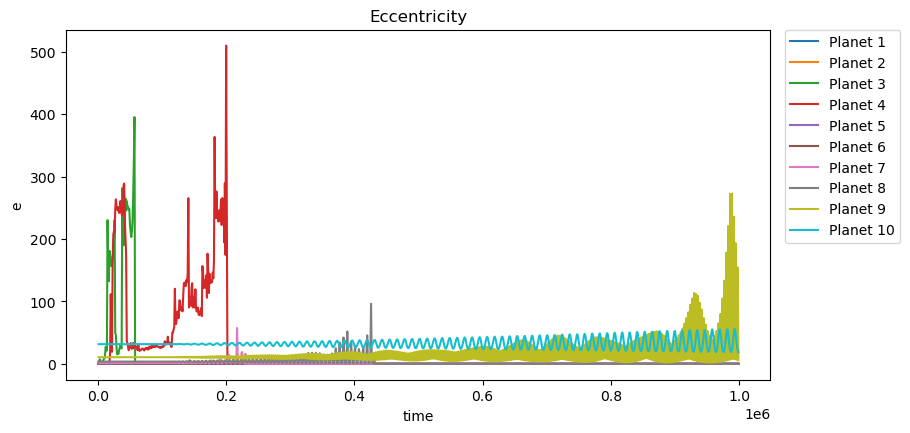

In [15]:
%matplotlib inline
elm = orbitalelementshash
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(221)
ax.set_xlabel("time")
ax.set_ylabel("e")
ax.set_title("Eccentricity")
#ax.set_yscale("log")
#plt.xlim(0, 2000)
#print(times)
count = 1
for i in elm.keys():
    plt.plot(elm[i][0][0], elm[i][0][1], label = "Planet " + str(count))
    count += 1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

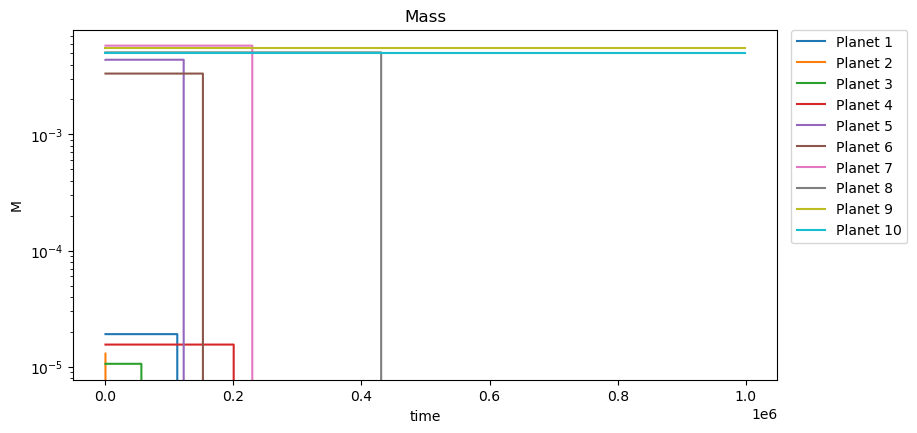

In [17]:
%matplotlib inline
elm = orbitalelementshash
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(221)
ax.set_xlabel("time")
ax.set_ylabel("M")
ax.set_title("Mass")
ax.set_yscale("log")
#plt.xlim(0, 2000)
#print(times)
count = 1
for i in elm.keys():
    plt.plot(elm[i][0][0], elm[i][0][4], label = "Planet " + str(count))
    count += 1
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [20]:
print(h('inner_p1'))
print(h('outer_p0'))

c_uint(848020557)
c_uint(346472202)


In [25]:
print(orbitalelementshash[346472202][0][4])

[0.00438291 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592
 0.00439592 0.00439592 0.00439592 0.00439592 0.00439592 0.0043